In [9]:
import os
os.chdir('../../../../src')

FileNotFoundError: [Errno 2] No such file or directory: '../../../../src'

In [2]:
from data import PolygonSentenceReader, Polygon
from modules import NLLLoss, ELBOLoss
from neural_process.models.np import CNP, LNP
from neural_process.models.attnnp import AttnCNP, AttnLNP
from utils import plot_polygon

import datetime
import random
import torch
import torch.nn as nn
from torch.distributions.kl import kl_divergence

In [3]:
TRAINING_ITERATIONS = int(3e5)
PLOT_AFTER = int(2e4)
BATCH_SIZE = 64
MAX_CONTEXT_POINTS = 10
MIN_SIDES = 3
MAX_SIDES = 8
x_size = 4 + 3 * MAX_SIDES
y_size = MAX_SIDES
torch.manual_seed(0)

criterion = ELBOLoss()

# Instantiate a polygon generator.
# (For example, polygons with between 3 and 8 sides.)
polygon_generator_train = PolygonSentenceReader(
    batch_size=BATCH_SIZE,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=MIN_SIDES,
    max_num_sides=MAX_SIDES,
    center=(5, 5),
    radius=3,
    testing=False,
)

polygon_generator_test = PolygonSentenceReader(
    batch_size=100,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=MIN_SIDES,
    max_num_sides=MIN_SIDES,
    center=(5, 5),
    radius=3,
    testing=True,
)

model = AttnLNP(x_dim=x_size, y_dim=y_size, attention_type="multihead")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=TRAINING_ITERATIONS, eta_min=1e-6
)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
device = next(model.parameters()).device

# Training

In [4]:
# ----------------------
# Training Loop
# ----------------------
for it in range(TRAINING_ITERATIONS + 1):
    # Generate a batch of polygon completion tasks.
    (
        context_x,
        context_y,
        target_x,
        target_y,
        tokens,
        true_poly,
        max_seq_len,
        num_context,
    ) = polygon_generator_train.generate_polygon_batch_few_shot_completion_task()

    context_x = context_x.to(device)
    context_y = context_y.to(device)
    target_x = target_x.to(device)
    target_y = target_y.to(device)

    optimizer.zero_grad()
    # Forward pass: the NP model expects context_x, context_y, target_x, target_y.
    dist, z, q_zc, q_zct = model(context_x, context_y, target_x, target_y)
    loss = criterion(dist, q_zct, q_zc, target_y)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if it % 1000 == 0:
        print("Iteration: {}, train loss: {}".format(it, loss.item()))

    # ----------------------
    # Evaluation and Plotting
    # ----------------------
    if it % PLOT_AFTER == 0:
        # For plotting, we generate a single polygon sample.
        (
            context_x_eval,
            context_y_eval,
            target_x_eval,
            target_y_eval,
            tokens_eval,
            true_poly_eval,
            max_seq_len_eval,
            num_context_eval,
        ) = polygon_generator_test.generate_polygon_batch_few_shot_completion_task()

        context_x_eval = context_x_eval.to(device)
        context_y_eval = context_y_eval.to(device)
        target_x_eval = target_x_eval.to(device)
        target_y_eval = target_y_eval.to(device)

        # Forward pass through the model.
        test_dist, test_z, test_q_zc, test_q_zct = model(
            context_x_eval, context_y_eval, target_x_eval, target_y_eval
        )
        loss = criterion(test_dist, q_zct, q_zc, target_y_eval)

        print(
            "{}, Iteration: {}, Test Loss: {}".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                it,
                loss.item(),
            )
        )

        # Get NP predictions on target tokens (taking the mean of the predictive distribution).
        pred_target = test_dist.mean  # shape: [n_z, batch, n_target, y_dim]

        # For simplicity, we average over latent samples and batch dimension.
        pred_target_avg = pred_target.mean(0).squeeze(1)  # shape: [n_target, y_dim]

        # print("pred_target_avg shape: ", pred_target_avg.shape)
        pred_target_avg = pred_target_avg[0]
        true_polygon = true_poly_eval[0]
        true_polygon_tokenised = true_polygon.to_tokenised()
        # print("pred_target_avg shape after squeeze: ", pred_target_avg.shape)

        print("True Polygon: ", true_polygon)
        print("True Polygon Angles: ", true_polygon.angles)
        print("Predicted Polygon Angles: ", pred_target_avg.tolist()[:len(true_polygon.angles)])

Iteration: 0, train loss: 45464040.0
2025-04-28 11:51:00, Iteration: 0, Test Loss: 45464040.0
True Polygon:  Polygon(n=3, vertices=[(4.7, 7.98), (6.29, 2.29), (7.36, 3.15)], lengths=[5.907977657371429, 1.3727709204379295, 5.514027566126234], angles=[13.230298030435634, 66.82218825216269, 99.94751371740168])
True Polygon Angles:  [13.230298030435634, 66.82218825216269, 99.94751371740168]
Predicted Polygon Angles:  [51.20598602294922, -13.135754585266113, 20.069040298461914]
Iteration: 1000, train loss: 625627.5
Iteration: 2000, train loss: 542710.0
Iteration: 3000, train loss: 4927.32763671875
Iteration: 4000, train loss: 1476.8717041015625
Iteration: 5000, train loss: 1382.4464111328125
Iteration: 6000, train loss: 522.1732788085938
Iteration: 7000, train loss: 426.6539001464844
Iteration: 8000, train loss: 373.49383544921875
Iteration: 9000, train loss: 278.81329345703125
Iteration: 10000, train loss: 125.42213439941406
Iteration: 11000, train loss: 31.211933135986328
Iteration: 12000

In [5]:
torch.save(model.state_dict(), "../models/polygon/np/" + model.__class__.__name__ + "_angles_completion_task_attn.pt")

In [4]:
model.load_state_dict(
    torch.load("../models/polygon/np/" + model.__class__.__name__ + "_angles_completion_task_attn.pt")
)

<All keys matched successfully>

# In-distribution performance over polygons of length 3 to 9 at 10 context points over 10 runs

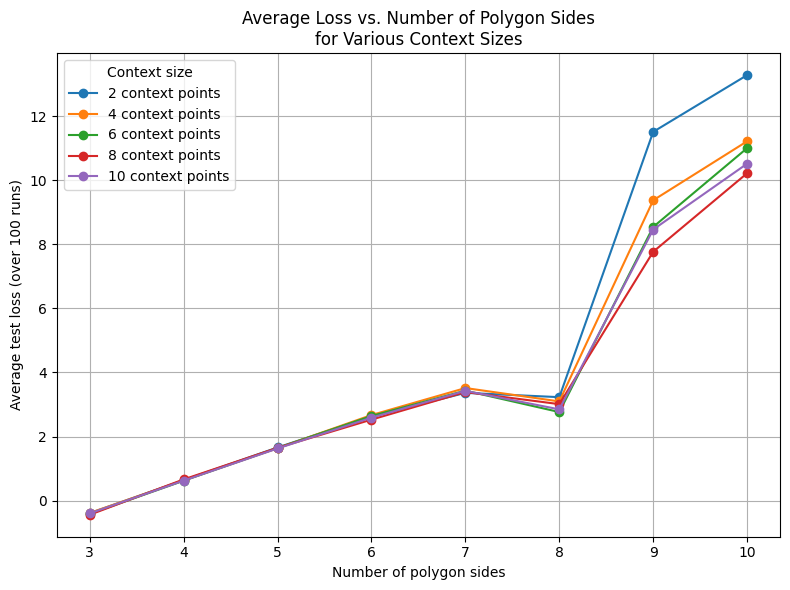

In [8]:
import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 100
sides_list = list(range(3, 11))
context_points_list = [2, 4, 6, 8, 10]
avg_losses = []
criterion = NLLLoss()

plt.figure(figsize=(8, 6))

for num_context in context_points_list:
    avg_losses = []
    for sides in sides_list:
        losses = []
        polygon_generator_test = PolygonSentenceReader(
            batch_size=BATCH_SIZE,
            max_num_context=num_context,
            max_seq_len=x_size,
            min_num_sides=sides,
            max_num_sides=sides,
            center=(5, 5),
            radius=3,
            testing=True,
        )
        (
            context_x_eval,
            context_y_eval,
            target_x_eval,
            target_y_eval,
            *_,
        ) = polygon_generator_test.generate_polygon_batch_few_shot_completion_task(num_context)

        context_x_eval = context_x_eval.to(device)
        context_y_eval = context_y_eval.to(device)
        target_x_eval = target_x_eval.to(device)
        target_y_eval = target_y_eval.to(device)

        test_dist, _, _, _ = model(
            context_x_eval, context_y_eval, target_x_eval, target_y_eval
        )
        loss = criterion(test_dist, target_y_eval)
        losses.append(loss.item())

        avg_losses.append(np.mean(losses))

    plt.plot(sides_list,
             avg_losses,
             marker='o',
             label=f'{num_context} context{" point" if num_context==1 else " points"}')

plt.xlabel("Number of polygon sides")
plt.ylabel("Average test loss (over 100 runs)")
plt.title("Average Loss vs. Number of Polygon Sides\nfor Various Context Sizes")
plt.xticks(sides_list)
plt.grid(True)
plt.legend(title="Context size")
plt.tight_layout()
plt.show()

# Out-of-distribution

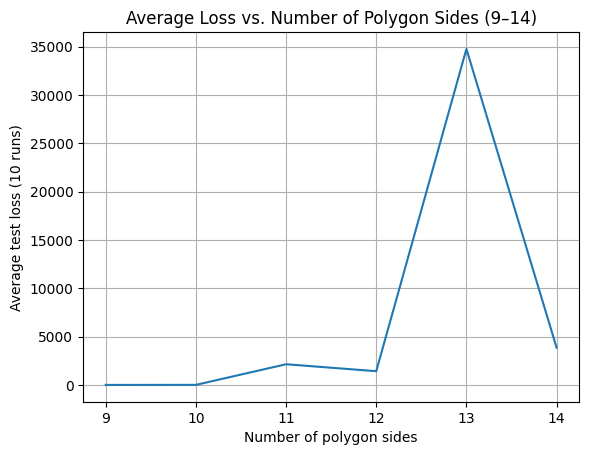

In [32]:
sides_list = list(range(9, 15))
avg_losses = []

for sides in sides_list:
    losses = []
    for run in range(10):
        poly_gen = PolygonSentenceReader(
            batch_size=1,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=sides,
            max_num_sides=sides,
            center=(5, 5),
            radius=3,
            testing=True,
        )
        (cx, cy, tx, ty, *_) = poly_gen.generate_polygon_batch_few_shot_completion_task(10)
        cx, cy, tx, ty = cx.to(device), cy.to(device), tx.to(device), ty.to(device)

        dist, z, q_zc, q_zct = model(cx, cy, tx, ty)
        loss = criterion(dist, q_zct, q_zc, ty)
        losses.append(loss.item())

    avg_losses.append(np.mean(losses))

# Plot
plt.figure()
plt.plot(sides_list, avg_losses)
plt.xlabel("Number of polygon sides")
plt.ylabel("Average test loss (10 runs)")
plt.title("Average Loss vs. Number of Polygon Sides (9–14)")
plt.xticks(sides_list)
plt.grid(True)
plt.show()

# In-distribution performance over polygons of length 5 over context points 3 to 10 over 10 runs

Sides: 5, Context: 3, Mean Loss: 1.6775 ± 0.2968
Sides: 5, Context: 4, Mean Loss: 1.6271 ± 0.2620
Sides: 5, Context: 5, Mean Loss: 1.7615 ± 0.4123
Sides: 5, Context: 6, Mean Loss: 1.6105 ± 0.2085
Sides: 5, Context: 7, Mean Loss: 1.6804 ± 0.2505
Sides: 5, Context: 8, Mean Loss: 1.6036 ± 0.2928
Sides: 5, Context: 9, Mean Loss: 1.6495 ± 0.3060
Sides: 5, Context: 10, Mean Loss: 1.6474 ± 0.2616


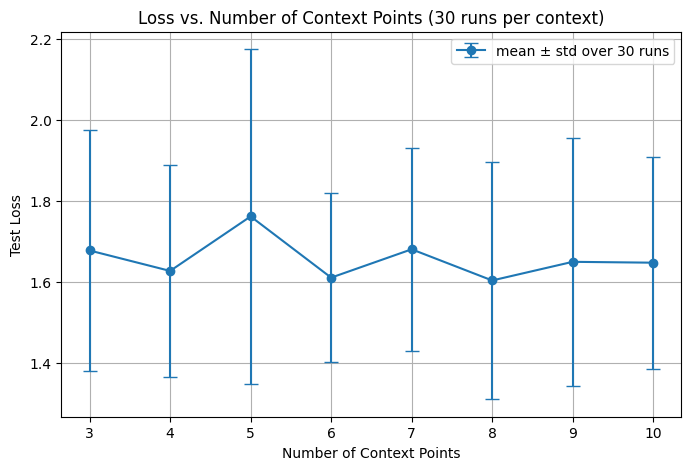

In [44]:
context_values = list(range(3, 11))
runs = 30

# holders for plotting
all_contexts = []
all_losses   = []
mean_losses  = []
std_losses   = []

for context in context_values:
    losses = []
    for run in range(runs):
        # --- generate one evaluation batch ---
        polygon_generator_test = PolygonSentenceReader(
            batch_size=1,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=5,
            max_num_sides=5,
            center=(5, 5),
            radius=3,
            testing=True,
        )
        (
            context_x_eval,
            context_y_eval,
            target_x_eval,
            target_y_eval,
            tokens_eval,
            true_poly_eval,
            max_seq_len_eval,
            num_context_eval,
        ) = polygon_generator_test.generate_polygon_batch_few_shot_completion_task(context)

        context_x_eval = context_x_eval.to(device)
        context_y_eval = context_y_eval.to(device)
        target_x_eval  = target_x_eval.to(device)
        target_y_eval  = target_y_eval.to(device)

        # forward + loss
        test_dist, test_z, test_q_zc, test_q_zct = model(
            context_x_eval, context_y_eval, target_x_eval, target_y_eval
        )
        loss = criterion(test_dist, test_q_zct, test_q_zc, target_y_eval)
        l = loss.item()
        losses.append(l)

        # keep for scatter
        all_contexts.append(context)
        all_losses.append(l)

    # after 10 runs, record mean & std
    mean_losses.append(np.mean(losses))
    std_losses.append(np.std(losses))
    print(f"Sides: 5, Context: {context}, "
          f"Mean Loss: {mean_losses[-1]:.4f} ± {std_losses[-1]:.4f}")

# now plot
plt.figure(figsize=(8,5))
# scatter of all individual runs
# plt.scatter(all_contexts, all_losses, alpha=0.4, label="individual runs")
# error‐bars for mean ± std
plt.errorbar(context_values, mean_losses, yerr=std_losses,
             fmt='-o', capsize=5, label="mean ± std over 30 runs")

plt.xlabel("Number of Context Points")
plt.ylabel("Test Loss")
plt.title("Loss vs. Number of Context Points (30 runs per context)")
plt.xticks(context_values)
plt.grid(True)
plt.legend()
plt.show()